# Importaciones generales

In [1]:

%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters
# %cd D:\CodeProjects\Python\Bayesian-Learning-with-Wasserstein-Barycenters\
# Soy una nueva linea

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


In [2]:


from torch import linalg as LA

from bwb import sgdw, utils
from bwb.distributions import *
from bwb.distributions.data_loaders import *
from bwb.geodesics import *
from bwb.transports import *

In [3]:
import logging
from bwb.logging import log_config
import time
from pathlib import Path

# Remove the handlers
log_config.remove_all_handlers()

# Define and add FileHandler
LOG_PATH = Path("logs") / f"notebook_{time.strftime('%Y%m%d_%H%M%S')}.log"
fh = logging.FileHandler(LOG_PATH)
log_config.set_default_formatter(fh)
log_config.add_handler(fh)

_log = log_config.get_logger("notebook")
print(_log.level)
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.INFO, name="bwb.utils")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.sgdw")
log_config.set_level(level=logging.INFO, name="bwb.transports")

30


In [4]:
_log.level

10

# Cargar datos

In [5]:
CURRENT_PATH = Path(".")
DATA_PATH = CURRENT_PATH / Path("data")
FACE_PATH = DATA_PATH / Path("face.npy")
FACE_PATH

PosixPath('data/face.npy')

In [6]:
arr = np.load(FACE_PATH)
arr.shape

(161666, 784)

In [7]:
shape = (28, 28)
faces = DistributionDrawDataLoader(arr, shape)
faces

DistributionDrawDataLoader((n_models, n_supp)=(161666, 784))

In [8]:
first_face = faces[0]
first_face

In [9]:
max_images = 36
faces_list = []
for k in range(max_images):
    faces_list.append(faces[k])

In [10]:
utils.plot_list_of_draws(faces_list, max_images=max_images)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/discrete_distribution.py:299: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  self._grayscale = _grayscale(to_return, weights, support)


## Construir Posterior

In [11]:
x = first_face.sample((3,))
x

tensor([690, 506, 506], device='cuda:0')

In [12]:
from bwb.config import config

gen = torch.Generator(device=config.device).manual_seed(2147483647)
gen.initial_seed()
# gen.seed()
gen.initial_seed()

2147483647

In [13]:
%%time
pi_n: ExplicitPosteriorSampler[DistributionDraw] = ExplicitPosteriorSampler().fit(data=x, models=faces)
pi_n

CPU times: user 5.75 ms, sys: 1.87 ms, total: 7.61 ms
Wall time: 6.94 ms


ExplicitPosteriorSampler(n_data=3, n_models=161666, n_support=40154, samples=0)

# Calcular baricentros

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k=0$, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor inicial.

In [1]:
class Gamma:
    def __init__(self, a=1, b=0, c=1):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, k):
        return self.a / (self.b ** (1 / self.c) + k) ** self.c

In [3]:
window = 3

a_ = 0.5
params = dict(a=a_, b=a_+0.1, c=0.51)
gamma = Gamma(**params)

for t in range(window):
    print(f"{t = }; {gamma(t) = :.8f}")
print()

init = 300
for t in range(init, init + window):
    print(f"{t = }; {gamma(t) = :.8f}")
print()

init = 500
for t in range(init, init + window):
    print(f"{t = }; {gamma(t) = :.8f}")
print()

init = 3_000
for t in range(init, init + window):
    print(f"{t = }; {gamma(t) = :.8f}")
print()

init = 10_000
for t in range(init, init + window):
    print(f"{t = }; {gamma(t) = :.8f}")

t = 0; gamma(t) = 0.83333333
t = 1; gamma(t) = 0.42626727
t = 2; gamma(t) = 0.32218275

t = 300; gamma(t) = 0.02725004
t = 301; gamma(t) = 0.02720389
t = 302; gamma(t) = 0.02715797

t = 500; gamma(t) = 0.02100548
t = 501; gamma(t) = 0.02098410
t = 502; gamma(t) = 0.02096279

t = 3000; gamma(t) = 0.00842580
t = 3001; gamma(t) = 0.00842437
t = 3002; gamma(t) = 0.00842294

t = 10000; gamma(t) = 0.00455997
t = 10001; gamma(t) = 0.00455974
t = 10002; gamma(t) = 0.00455950


## Baricentro con 50 caras, 3 datos

In [16]:
faces = DistributionDrawDataLoader(arr[:100, :], shape)
faces

DistributionDrawDataLoader((n_models, n_supp)=(100, 784))

In [17]:
x = first_face.sample((3,))
x

tensor([289, 445, 125], device='cuda:0')

In [18]:
pi_n: ExplicitPosteriorSampler[DistributionDraw] = ExplicitPosteriorSampler().fit(data=x, models=faces)
pi_n

ExplicitPosteriorSampler(n_data=3, n_models=100, n_support=50, samples=0)

In [19]:
probs = pi_n.probabilities_
torch.round(pi_n.probabilities_[torch.round(probs, decimals=4) > 0] * 100, decimals=2)

tensor([2.5700e+01, 9.7000e-01, 3.2500e+00, 8.0000e-01, 7.9700e+00, 2.0200e+00,
        2.8200e+00, 1.0000e-02, 6.5000e-01, 1.5000e+00, 4.0300e+00, 3.3900e+00,
        2.9800e+00, 1.9000e-01, 2.7740e+01, 2.5700e+00, 3.2200e+00, 1.8000e-01,
        1.0010e+01], device='cuda:0', dtype=torch.float64)

In [20]:
transport = EMDTransport(max_iter=250_000)

In [21]:
X_k, m, pos_hist, samples_hist = sgdw.sgdw.compute_bwb_discrete_distribution(
    transport=transport,
    distrib_sampler=pi_n,
    learning_rate=Gamma(**params),
    batch_size=1,
    alpha=0.01,
    tol=0.,
    max_iter=500,
    max_time=0.5,
    position_history=True,
    distrib_sampler_history=True,
    report_every=20
)

/tmp/ipykernel_12030/3921458817.py:1: DeprecationWarning: This function is deprecated. Use the DiscreteDistributionSGDW class instead.
  X_k, m, pos_hist, samples_hist = sgdw.sgdw.compute_bwb_discrete_distribution(


### Primeras iteraciones

In [22]:
utils.plot_list_of_draws([DistributionDraw(m, shape, X) for X in pos_hist[:36]], max_images=36)

In [23]:
utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=33)

### Últimas iteraciones

In [24]:
utils.plot_list_of_draws([DistributionDraw(m, shape, X) for X in pos_hist[-36:]], max_images=36)

In [25]:
utils.plot_list_of_draws([x[0] for x in samples_hist[-33:]], max_images=33)

## Baricentro usando la clase, con 50 caras y 3 datos

In [26]:
dd_sgdw = sgdw.DiscreteDistributionSGDW(
    transport=transport,
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    batch_size=1,
    alpha=0.01,
    tol=0.,
    max_iter=500,
    max_time=10,
    report_every=20
)


In [27]:
dd_sgdw.hist

History(pos_wgt=False, distr=False, pos_wgt_samp=False, distr_samp=False, len=0)

In [28]:
# from bwb.sgdw.plotters import PlotterComparison

# plotter = PlotterComparison(dd_sgdw)

print(dd_sgdw.iter_params)
bar, hist = dd_sgdw.run(
    pos_wgt_hist=True,
    distr_samp_hist=True,
)
# out, out2 = dd_sgdw.run(pos_wgt_hist=True, distr_hist=True)
print(dd_sgdw.iter_params)
pos_wgt_hist, distr_samp_hist = hist.pos_wgt, hist.distr_samp

IterationParameters(k=0, w_dist=∞, t=0:00:00.00, Δt=0.00 [ms])
IterationParameters(k=435, w_dist=0.000673, t=0:00:10.00, Δt=21.78 [ms])


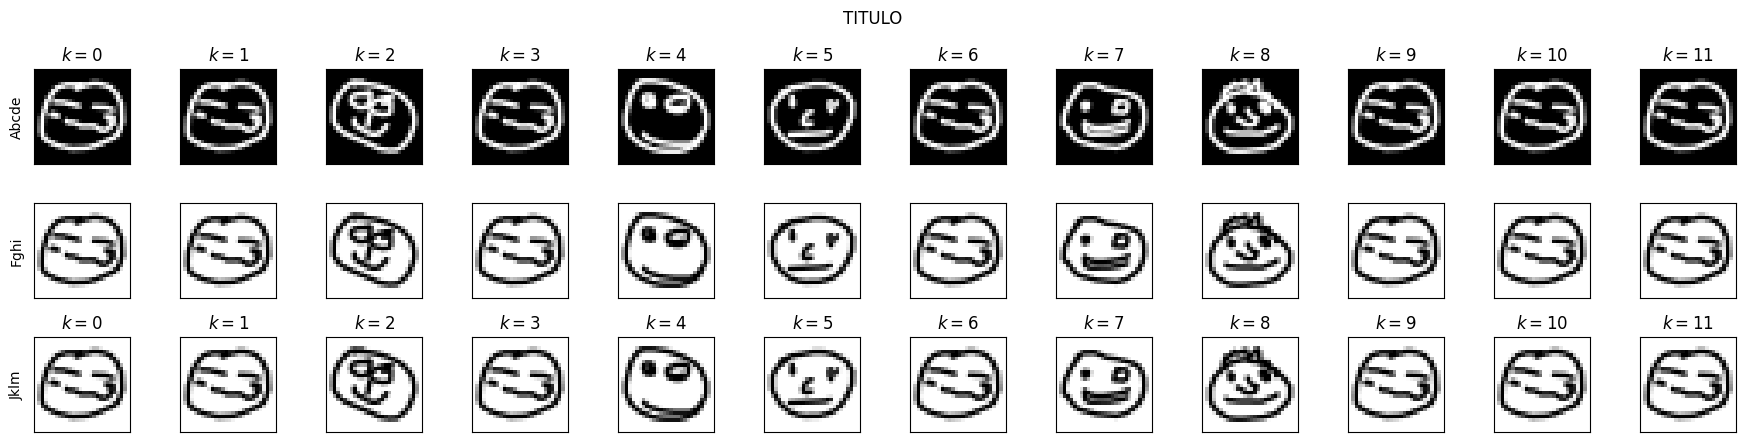

In [29]:
import matplotlib.pyplot as plt

row, col = 3, 12
factor = 1.5

fig, axes = plt.subplots(row, col, figsize=(col * factor, row * factor), subplot_kw={"xticks": [], "yticks": []})

fig.suptitle("TITULO")

for j in range(col):
    img: DistributionDraw = hist.distr_samp[j][0]
    ax1, ax2, ax3 = axes[0, j], axes[1, j], axes[2, j]
    # ax1.set_axis_off()
    if j == 0:
        ax1.set_ylabel("Abcde")
        ax2.set_ylabel("Fghi")
        ax3.set_ylabel("Jklm")

    ax1.imshow(img.image, cmap="binary")
    ax2.imshow(img.image, cmap="binary_r")
    ax3.imshow(img.image, cmap="binary_r")
    ax1.set_title(f"$k={j}$")
    ax3.set_title(f"$k={j}$")

plt.tight_layout(w_pad=0.1)

In [30]:
img.image

In [31]:
dd_sgdw.iter_params

IterationParameters(k=435, w_dist=0.000673, t=0:00:10.00, Δt=21.78 [ms])

In [32]:
DistributionDraw.from_discrete_distribution(bar, shape)

### Primeras iteraciones

In [33]:
utils.plot_list_of_draws([DistributionDraw(m, shape, X) for (X, m) in pos_wgt_hist[:36]], max_images=36)

In [34]:
utils.plot_list_of_draws([x[0] for x in distr_samp_hist[:33]], max_images=33)

### Últimas iteraciones

In [35]:
utils.plot_list_of_draws([DistributionDraw(m, shape, X) for (X, m) in pos_wgt_hist[-36:]], max_images=36)

In [36]:
utils.plot_list_of_draws([x[0] for x in distr_samp_hist[-33:]], max_images=33)

## Baricentro utilizando la GAN

In [37]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)
noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks"

FACE_PATH = NETS_PATH / f"cleaned_clustered_zDim128_norm_bs_128"
# FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_{NOISE}_bs_128_cleaned_augmented_WAE_WGAN_loss_l1_32p32"
# FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_{NOISE}_bs_128_cleaned_sin_contorno_augmented_WAE_WGAN_loss_l1_32p32"

from wgan_gp.wgan_gp_vae.utils import load_checkpoint

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval();
E.eval()
print()

In [38]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cuda)

In [39]:
z_ = torch.zeros((1,), device="cuda")
# # z = G.sample_noise(100, type_as=z_)
# G_script = torch.jit.script(G)
# # G_script(z)
# G, G_ = torch.jit.freeze(G_script), G
# G
G_ = G

In [40]:
with torch.cuda.amp.autocast():
    z = noise_sampler(1)
    print(z.dtype)

torch.float32


torch.float16
torch.float16
torch.float64


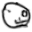

In [41]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning

disable_beta_transforms_warning()

import torchvision.transforms.v2 as T

with torch.cuda.amp.autocast():
    z = noise_sampler(1)
    m = G(z)
    print(m.dtype)
print(m.dtype)
transform_in = T.Compose(
    [
        T.Lambda(lambda x: x / torch.max(x)),
        T.ToPILImage(),
        T.Resize(32),
        T.ToImageTensor(),
        T.ConvertImageDtype(torch.float32),
        T.Normalize((0.5,), (0.5,)),
    ]
)
transform_out = T.Compose(
    [
        T.ToDtype(torch.float64),
        T.Lambda(lambda x: x.squeeze()),
        T.Lambda(lambda x: x - torch.min(x)),
        T.Lambda(lambda x: x / torch.sum(x)),
        T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
    ]
)
out: DistributionDraw = transform_out(m)
print(out.dtype)
out

In [42]:

z = noise_sampler(1)
for v in z:
    print(v.unsqueeze(0).shape)


torch.Size([1, 128, 1, 1])


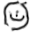

In [43]:
pi_n: GeneratorDistribSampler[DistributionDraw] = GeneratorDistribSampler()
pi_n.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out)
pi_n.draw()

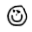

In [44]:
pi_n.draw()

In [45]:
mu_k, dist_hist, samples_hist = sgdw.sgdw.compute_bwb_distribution_draw(
    distrib_sampler=pi_n,
    learning_rate=Gamma(**params),
    reg=3e-3,
    max_iter=100,
    max_time=1,
    distribution_history=True,
    distrib_sampler_history=True,
)

AttributeError: module 'bwb.sgdw' has no attribute 'compute_bwb_distribution_draw'

In [ ]:
max_images = 22 * 4
utils.plot_list_of_draws(dist_hist, max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=max_images)

In [ ]:
utils.plot_list_of_draws(dist_hist[-max_images:], max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist[-max_images:]], max_images=max_images)

## Baricentro utilizando la GAN, y utilizando la clase

In [46]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=500,
    # max_time=10,
    report_every=10,
)
dist_draw_sgdw.det_params

DetentionParameters(tol=0.00e+00, max_iter=500, max_time=∞)

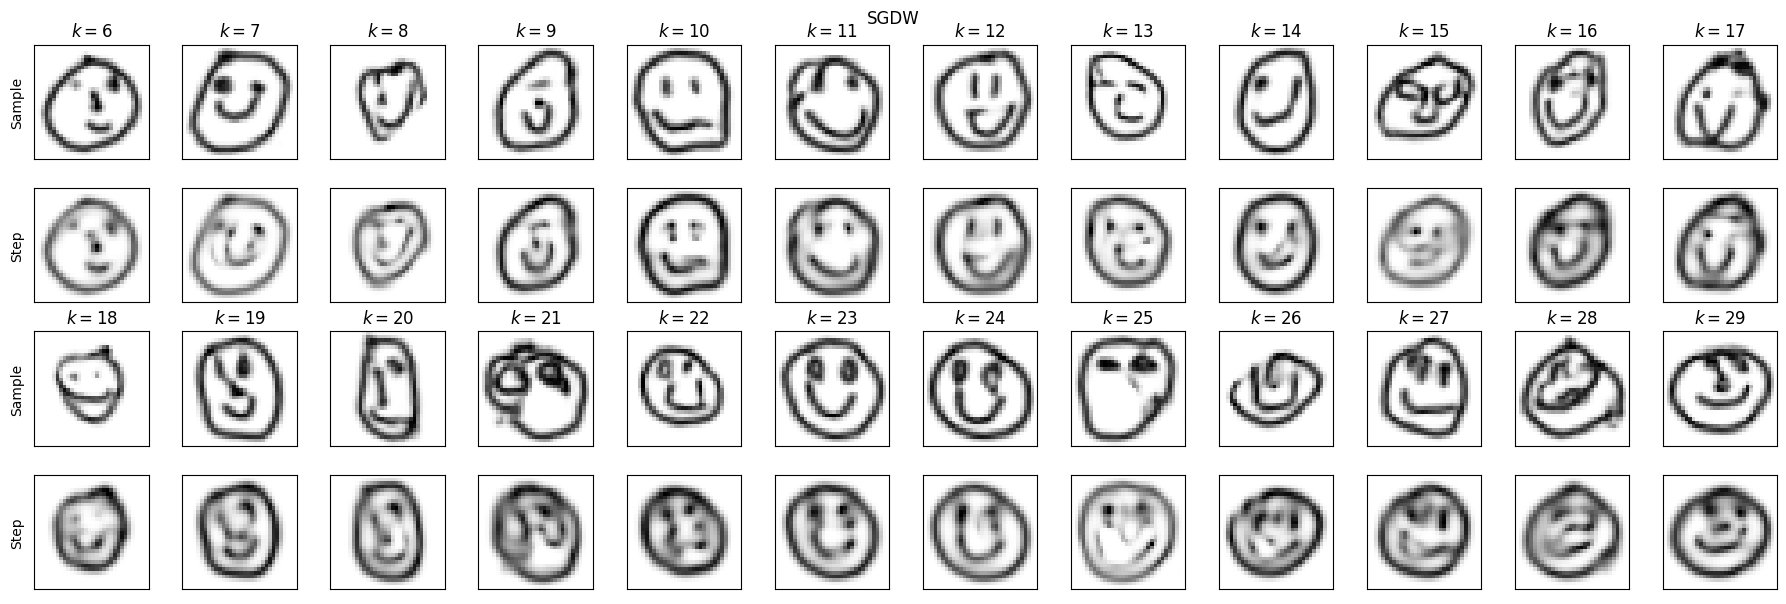

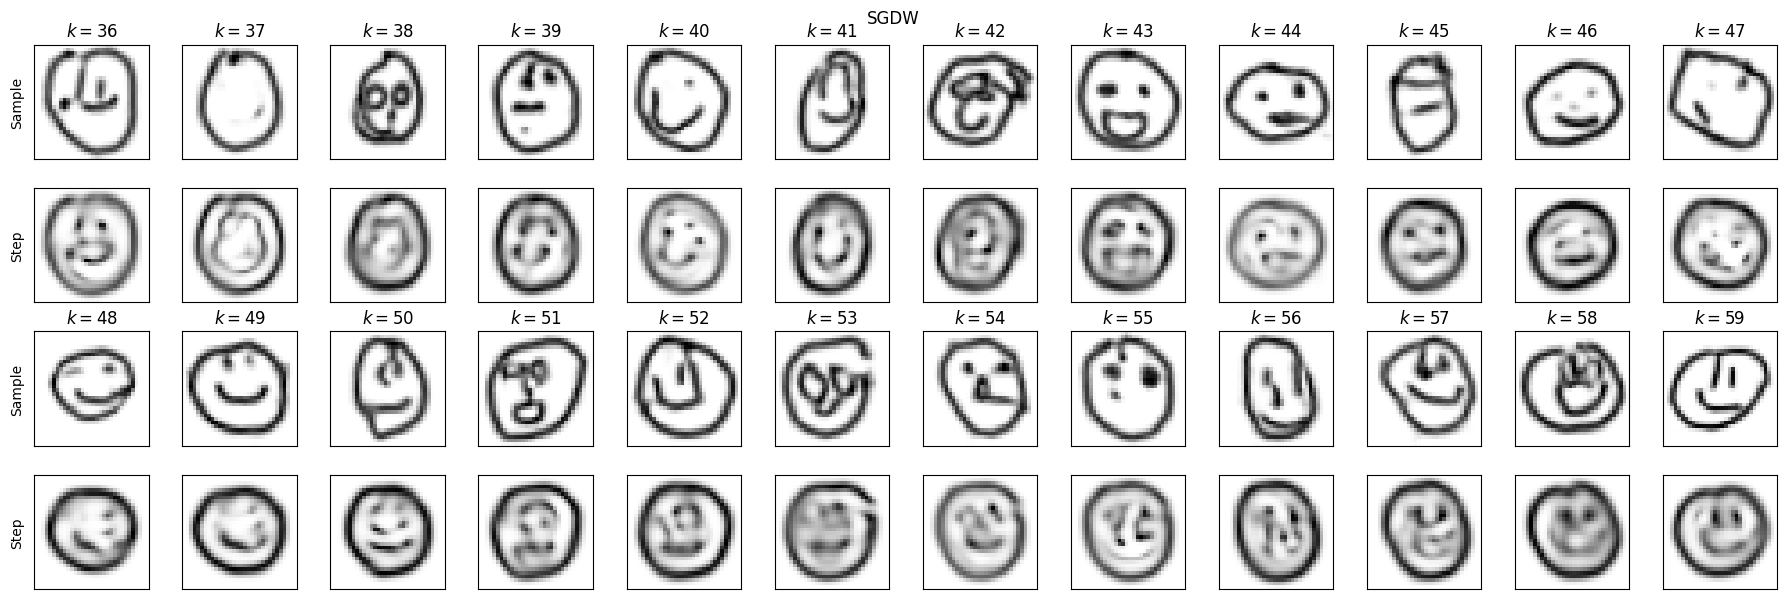

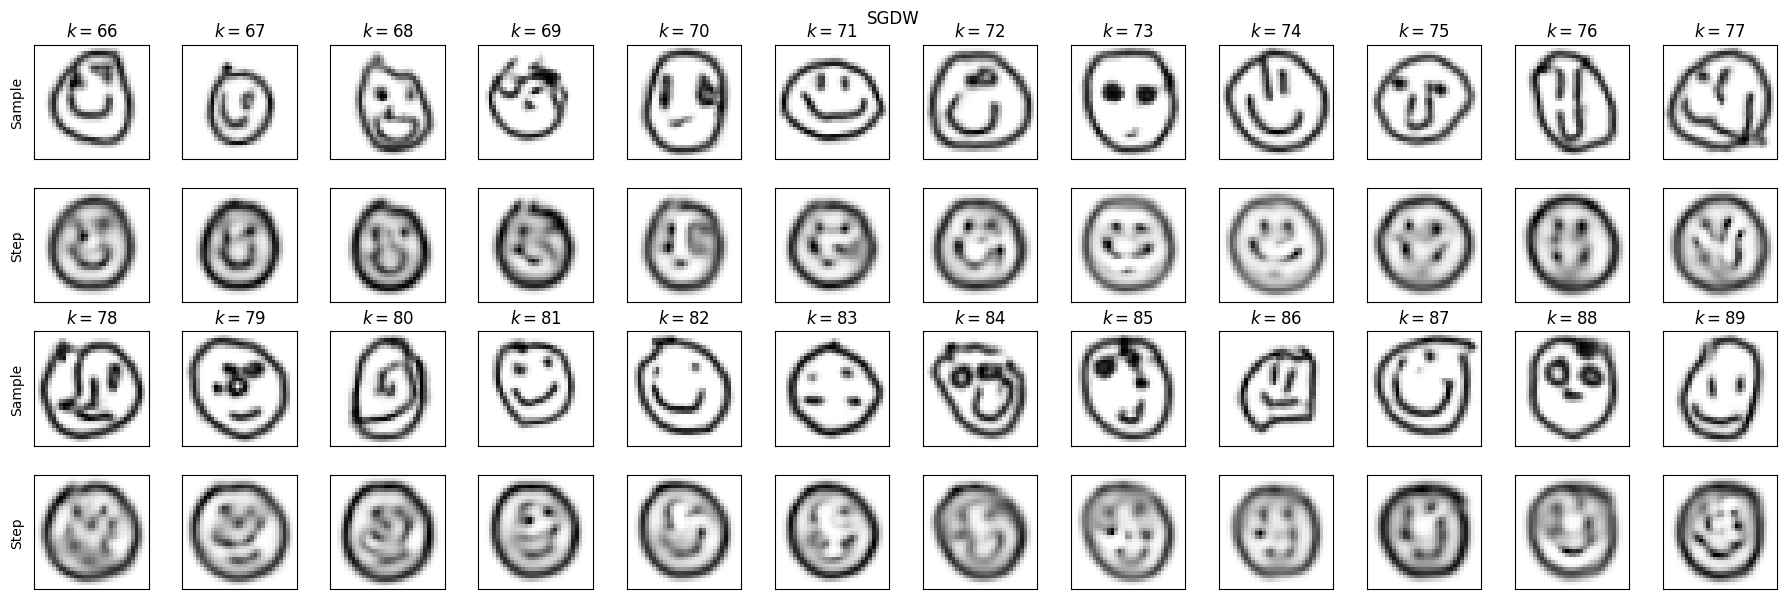

In [71]:
from bwb.sgdw.plotters import Plotter
from bwb.distributions import DistributionDraw
from bwb.sgdw.sgdw import BaseSGDW
from bwb.utils import _DistributionT
from bwb.sgdw.utils import _PosWgt


# noinspection PyShadowingNames
class PlotterComparison(Plotter[DistributionDraw, torch.Tensor]):

    def __init__(
        self,
        sgdw: BaseSGDW[_DistributionT, _PosWgt],
        plot_every=50,
        n_cols=12,
        n_rows=1,
        factor=1.5,
        cmap="binary"
    ):
        super().__init__(sgdw, plot_every, n_cols, n_rows, factor, cmap)
        if n_rows * n_cols > plot_every:
            msg = f"'plot_every' should not be less than n_rows * n_cols. Currently: {plot_every = } < {n_rows * n_cols = }"
            raise ValueError(msg)
        self.pos_wgt_hist = True
        self.pos_wgt_samp_hist = True

    def plot(self, init: int = None):
        create_distr = self.sgdw.create_distribution
        max_imgs = self.n_rows * self.n_cols
        max_k = self.sgdw.iter_params.k
        init = max_k - max_imgs + 1 if init is None else init

        row, col = self.n_rows * 2, self.n_cols

        fig, ax = plt.subplots(
            row, col, figsize=(col * self.factor, row * self.factor),
            subplot_kw={"xticks": [], "yticks": []}
        )

        fig.suptitle("SGDW")

        for i in range(self.n_rows):
            for j in range(self.n_cols):
                k = init + j + i * self.n_cols
                # print(f"{i = }, {j = }, {k = }")
                ax0, ax1 = ax[i * 2, j], ax[i * 2 + 1, j]

                # Label the y-axis
                if j == 0:
                    ax0.set_ylabel("Sample")
                    ax1.set_ylabel("Step")

                # Plot the sample
                fig_sample: DistributionDraw = create_distr(hist.pos_wgt_samp[k][0])
                ax0.imshow(fig_sample.image, cmap=self.cmap)
                ax0.set_title(f"$k={k}$")

                # Plot the step
                fig_step: DistributionDraw = create_distr(hist.pos_wgt[k])
                ax1.imshow(fig_step.image, cmap=self.cmap)

        plt.tight_layout(pad=0.3)

        plt.show()

        return fig, ax


dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    step_scheduler=Gamma(**params),
    max_iter=100,
    # max_time=10,
    report_every=10,
).set_geodesic_params(
    reg=0.01,
    stop_thr=1e-3,
)

plotter = PlotterComparison(dist_draw_sgdw, plot_every=30, n_cols=12, n_rows=2, cmap="binary_r")

bar, hist = plotter.run(
    # distr_hist=True,
    # distr_samp_hist=True,
    include_dict=dict(total_time=True),
    # include_time=True,
)
dist_hist, samples_hist = hist.distr, hist.distr_samp

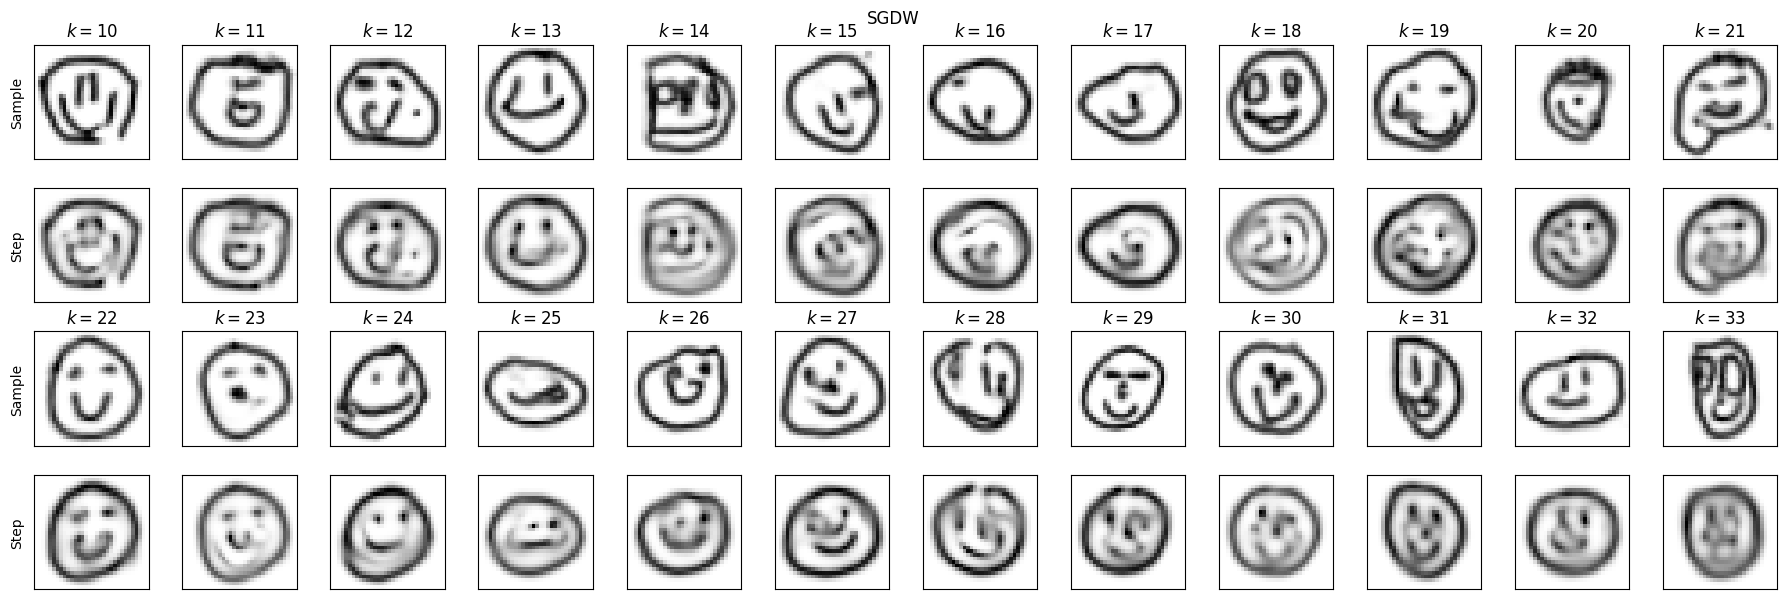

In [72]:
fig, _ = plotter.plot(10)

IndexError: index 12 is out of bounds for axis 1 with size 12

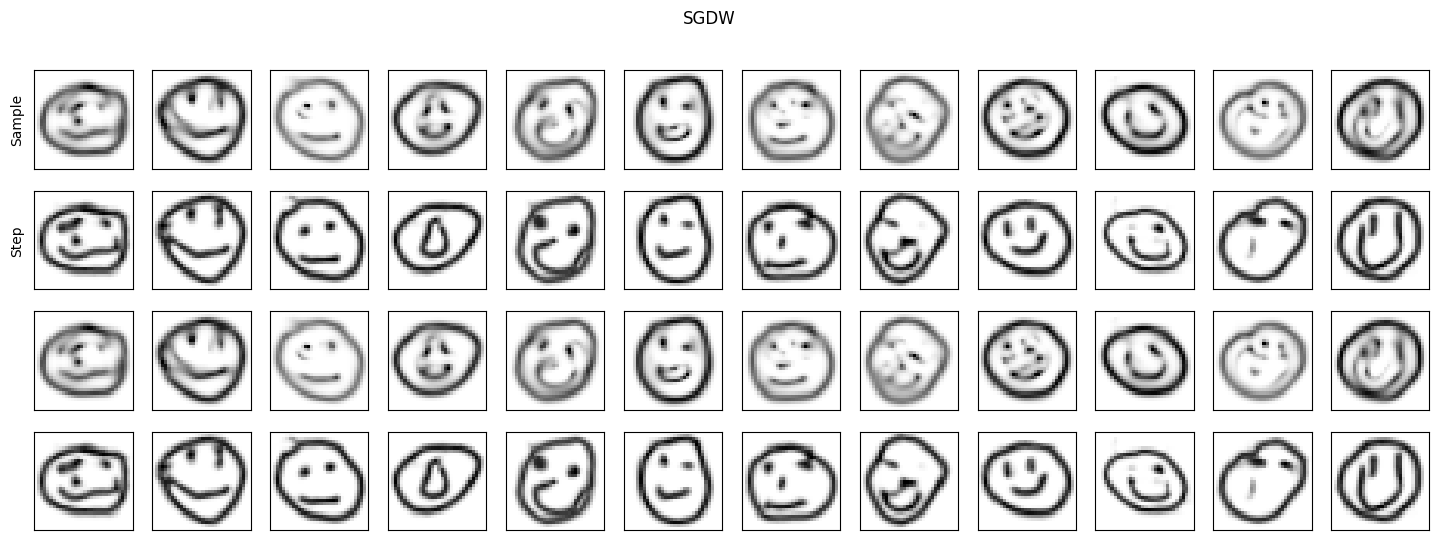

In [50]:
dist_draw_sgdw.set_geodesic_params(
    reg=0.01,
    stop_thr=1e-3,
)

plotter = PlotterComparison(dist_draw_sgdw, plot_every=30, n_rows=2, cmap="binary_r")

bar, hist = plotter.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_dict=dict(total_time=True),
    # include_time=True,
)
dist_hist, samples_hist = hist.distr, hist.distr_samp

In [59]:
Gamma(**params)(10000)

0.027347506467497788

In [47]:
import ot

ot.__version__

'0.9.3dev'

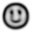

In [48]:
bar


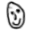
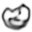
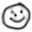
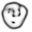
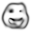
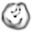
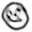
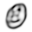
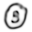
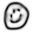
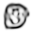
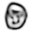
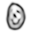
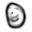
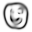
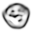
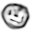
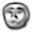
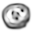
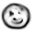
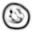
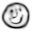
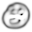
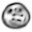
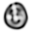
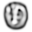
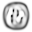
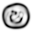
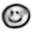
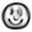
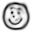
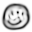
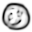
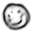
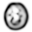
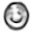
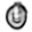
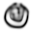
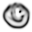
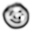
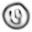
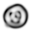
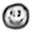


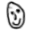
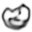
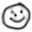
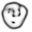
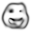
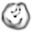
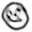
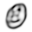
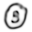
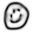
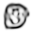
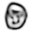
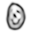
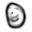
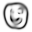
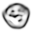
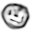
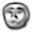
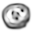
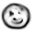
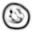
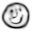
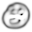
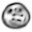
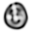
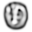
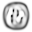
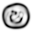
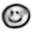
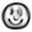
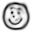
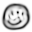
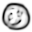
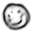
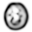
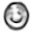
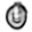
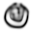
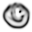
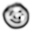
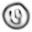
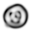
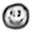

In [49]:
max_images = 22 * 4
utils.plot_list_of_draws(dist_hist, max_images=max_images)


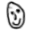
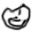
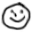
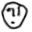
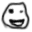
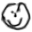
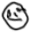
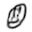
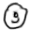
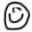
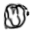
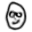
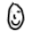
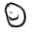
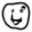
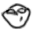
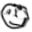
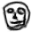
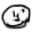
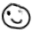
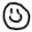
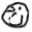
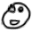
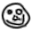
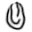
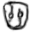
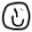
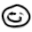
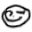
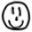
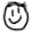
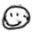
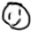
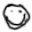
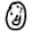
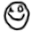
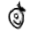
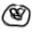
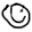
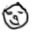
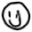
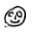
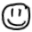


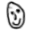
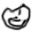
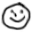
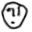
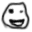
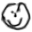
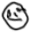
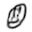
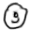
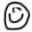
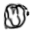
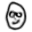
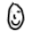
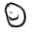
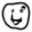
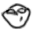
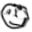
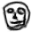
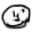
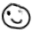
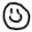
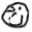
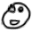
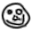
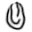
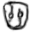
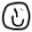
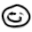
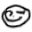
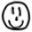
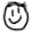
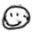
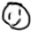
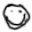
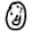
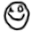
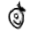
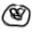
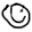
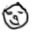
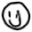
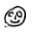
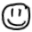

In [50]:
utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=max_images)


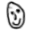
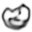
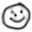
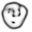
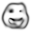
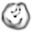
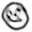
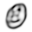
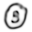
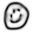
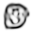
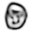
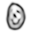
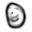
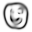
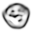
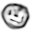
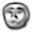
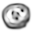
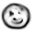
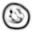
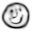
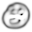
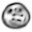
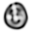
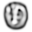
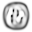
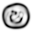
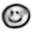
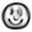
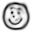
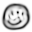
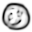
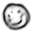
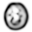
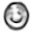
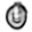
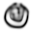
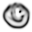
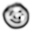
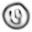
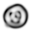
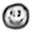


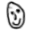
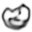
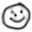
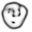
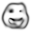
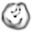
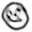
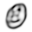
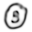
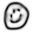
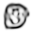
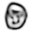
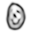
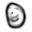
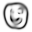
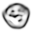
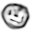
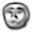
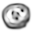
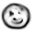
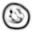
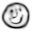
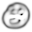
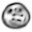
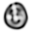
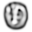
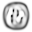
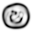
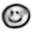
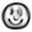
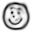
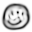
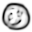
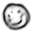
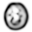
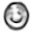
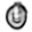
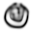
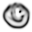
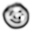
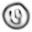
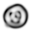
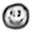

In [51]:
utils.plot_list_of_draws(dist_hist[-max_images:], max_images=max_images)


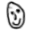
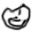
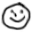
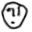
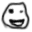
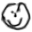
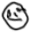
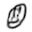
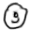
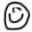
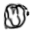
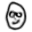
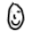
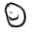
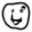
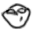
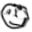
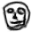
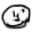
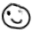
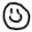
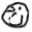
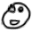
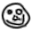
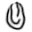
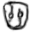
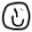
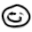
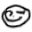
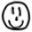
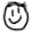
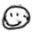
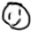
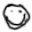
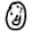
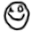
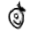
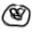
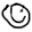
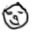
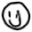
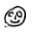
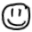


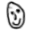
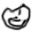
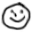
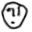
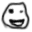
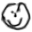
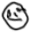
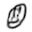
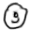
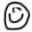
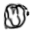
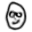
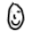
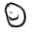
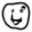
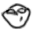
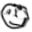
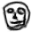
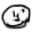
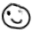
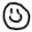
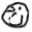
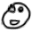
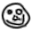
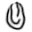
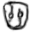
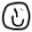
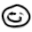
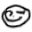
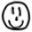
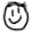
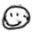
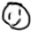
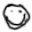
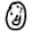
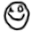
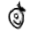
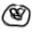
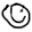
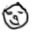
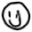
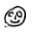
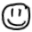

In [52]:
utils.plot_list_of_draws([x[0] for x in samples_hist[-max_images:]], max_images=max_images)

In [85]:
# X_k, m, pos_hist, samples_hist = sgdw.compute_bwb_discrete_distribution(
#     transport=transport,
#     distrib_sampler=pi_n,
#     learning_rate=Gamma(**params),
#     batch_size=1,
#     alpha=1e-6,
#     tol=0.,
#     max_iter=500,
#     max_time=30,
#     position_history=True,
#     distrib_sampler_history=True,
#     report_every=20
# )

### Primeras iteraciones

In [86]:
# utils.plot_list_of_draws([DistributionDraw(m, shape, X) for X in pos_hist[:36]], max_images=36)

In [87]:
# utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=33)

# Baricentro usando métodos convolucionales, con 50 caras, 3 datos

In [ ]:
mu_k, dist_hist, samples_hist = sgdw.compute_bwb_distribution_draw(
    distrib_sampler=pi_n,
    learning_rate=Gamma(**params),
    reg=3e-3,
    max_iter=500,
    max_time=30,
    distribution_history=True,
    distrib_sampler_history=True,
)

2024-03-20 13:44:31,557: INFO [bwb.sgdw:157]
> dtype = torch.float64, device = device(type='cuda', index=0)
2024-03-20 13:44:31,560: INFO [bwb.sgdw:178]
> ============ k = 0, t = 0.0000 [seg], Δt = 0.0000 [ms], Δt per iter. = 0.0002 [ms/iter] ============
2024-03-20 13:44:33,293: INFO [bwb.sgdw:178]
> ============ k = 10, t = 1.7323 [seg], Δt = 217.0606 [ms], Δt per iter. = 157.4824 [ms/iter] ============
2024-03-20 13:44:35,216: INFO [bwb.sgdw:178]
> ============ k = 20, t = 3.6561 [seg], Δt = 309.1550 [ms], Δt per iter. = 174.1012 [ms/iter] ============
2024-03-20 13:44:37,222: INFO [bwb.sgdw:178]
> ============ k = 30, t = 5.6614 [seg], Δt = 225.2445 [ms], Δt per iter. = 182.6256 [ms/iter] ============
2024-03-20 13:44:38,852: INFO [bwb.sgdw:178]
> ============ k = 40, t = 7.2913 [seg], Δt = 208.9715 [ms], Δt per iter. = 177.8374 [ms/iter] ============
2024-03-20 13:44:41,132: INFO [bwb.sgdw:178]
> ============ k = 50, t = 9.5722 [seg], Δt = 183.4087 [ms], Δt per iter. = 187.6905 [m

In [ ]:
max_images = 38
utils.plot_list_of_draws(dist_hist, max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=max_images)

In [ ]:
utils.plot_list_of_draws(dist_hist[-max_images:], max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist[-max_images:]], max_images=max_images)

# Baricentro usando métodos convolucionales y proyección sobre la variedad, con 50 caras, 3 datos

In [ ]:
import torch
from wgan_gp.wgan_gp_vae.model import Generator, Encoder
from wgan_gp.wgan_gp_vae.utils import load_checkpoint
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LATENT_DIM = 100
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG, NUM_FILTERS).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG, NUM_FILTERS[::-1]).to(device)

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks"
FACE_PATH = NETS_PATH / "face"

DATA_PATH = CURR_PATH / "data" / "face.npy"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

proj = ProjectorOnManifold(
    E, G,
    transform_in=transforms.Compose(
        [
            # From pdf to grayscale
            transforms.Lambda(lambda x: x / torch.max(x)),
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.5 for _ in range(1)],
                [0.5 for _ in range(1)],
            ),
        ]
    ),
    transform_out=transforms.Compose(
        [
            # Ensure the range is in [0, 1]
            transforms.Lambda(lambda x: x - torch.min(x)),
            transforms.Lambda(lambda x: x / torch.max(x)),
            transforms.ToPILImage(),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / torch.sum(x)),
            transforms.Lambda(lambda x: x.squeeze(0)),
        ]
    )
)

In [ ]:
mu_k, dist_hist, samples_hist = sgdw.compute_bwb_distribution_draw_projected(
    distrib_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    reg=2e-3,
    max_iter=500,
    max_time=30,
    distribution_history=True,
    distrib_sampler_history=True,
)

2024-03-20 13:46:18,897: INFO [bwb.sgdw:245]
> dtype = torch.float64, device = device(type='cuda', index=0)
2024-03-20 13:46:18,898: INFO [bwb.sgdw:266]
> ============ k = 0, t = 0.0000 [seg], Δt = 0.0000 [ms], Δt per iter. = 0.0000 [ms/iter] ============
2024-03-20 13:46:21,837: INFO [bwb.sgdw:266]
> ============ k = 10, t = 2.9397 [seg], Δt = 283.7451 [ms], Δt per iter. = 267.2487 [ms/iter] ============
2024-03-20 13:46:24,759: INFO [bwb.sgdw:266]
> ============ k = 20, t = 5.8613 [seg], Δt = 180.8181 [ms], Δt per iter. = 279.1077 [ms/iter] ============
2024-03-20 13:46:26,919: INFO [bwb.sgdw:266]
> ============ k = 30, t = 8.0214 [seg], Δt = 189.5194 [ms], Δt per iter. = 258.7551 [ms/iter] ============
2024-03-20 13:46:29,311: INFO [bwb.sgdw:266]
> ============ k = 40, t = 10.4139 [seg], Δt = 200.2206 [ms], Δt per iter. = 253.9973 [ms/iter] ============
2024-03-20 13:46:31,627: INFO [bwb.sgdw:266]
> ============ k = 50, t = 12.7296 [seg], Δt = 230.6070 [ms], Δt per iter. = 249.5999 

In [ ]:
max_images = 17 * 3
utils.plot_list_of_draws(dist_hist, max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist], max_images=max_images)

In [ ]:
utils.plot_list_of_draws(dist_hist[-max_images:], max_images=max_images)

In [ ]:
utils.plot_list_of_draws([x[0] for x in samples_hist[-max_images:]], max_images=max_images)

In [ ]:
%%time
geod = BarycentricProjGeodesic(EMDTransport(max_iter=250_000))
eps = 0.
max_time_iter = 10
max_iter = float("inf")
alpha = 1

# Camino de baricentros
position_historial = []

# Paso 1: samplear un mu_0
mu_0 = pi_n.draw()

# Calcular las masas y ubicaciones
X_k, m = utils.partition(X=mu_0.enumerate_nz_support_(), mu=mu_0.nz_probs, alpha=alpha)
position_historial.append(X_k)

_log.debug(f"{len(X_k) = }")

k = 0
tic, toc = time.time(), time.time()

while k < max_iter and toc - tic < max_time_iter:
    _log.debug("=" * 10 + f" {k = }, Δt = {toc - tic:.4f} [seg] " + "=" * 10)
    # Paso 2: Samplear \tilde\mu_k
    t_mu_k: DistributionDraw = pi_n.draw()
    t_X_k, t_m_k = t_mu_k.enumerate_nz_support_(), t_mu_k.nz_probs

    # Calcular transporte óptimo
    geod.fit(
        Xs=X_k, mu_s=m,
        Xt=t_X_k, mu_t=t_m_k,
    )
    T_X_k = geod.transport.transform(X_k)
    _log.debug(f"{T_X_k.shape = }")

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k);
    _log.debug(f"{gamma_k = :.6f}")
    X_kp1, _ = geod.interpolate(gamma_k)
    _log.debug(f"{X_kp1.shape = }")

    # Calcular la distancia de Wasserstein
    diff = X_k - T_X_k
    dist = float((gamma_k ** 2) * torch.sum(m * LA.norm(diff, dim=1) ** 2))
    _log.debug(f"{dist = :.8f}")

    while dist < eps:
        break

    position_historial.append(X_kp1)

    k += 1
    X_k = X_kp1
    toc = time.time()

In [ ]:
eps = 0.
alpha = 1. / 10
transp = EMDTransport()
max_time_iter = 10  # 60 * 60  # Una hora
max_iter = float("inf")

# Camino de baricentros
position_historial = []

# Paso 1: samplear un mu_0
mu_0 = pi_n.draw()

# Calcular las masas y ubicaciones
X, m_ = [], []
min_w, max_w = mu_0.nz_probs.min(), mu_0.nz_probs.max()

for x, w, n in zip(
    mu_0.enumerate_nz_support_(), mu_0.nz_probs,
    torch.ceil(alpha * mu_0.nz_probs / min_w).to(int)
):
    for _ in range(n):
        X.append(x.reshape(1, -1))
        m_.append(w / n)

X_k = torch.cat(X, 0)
m = torch.as_tensor(m_, dtype=mu_0.dtype, device=mu_0.device)
position_historial.append(X_k)

_log.debug(f"{len(X_k) = }")

k = 0

tic, toc = time.time(), time.time()

while k < max_iter and toc - tic < max_time_iter:
    _log.debug("\n" + "=" * 10 + f" {k = }, Δt = {toc - tic:.4f} [seg] " + "=" * 10)
    # Paso 2: Samplear \tilde\mu_k
    t_mu_k: DistributionDraw = pi_n.draw()
    t_X_k, t_m_k = t_mu_k.enumerate_nz_support_(), t_mu_k.nz_probs

    # Calcular transporte óptimo
    transp.fit(
        Xs=X_k, mu_s=m,
        Xt=t_X_k, mu_t=t_m_k,
    )
    T_X_k = transp.transform(X_k)
    _log.debug(f"{T_X_k.shape = }")

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k);
    _log.debug(f"{gamma_k = :.6f}")
    X_kp1 = (
                1 - gamma_k) * X_k + gamma_k * T_X_k  # Basta con calcular las transformaciones, porque los pesos son los mismos
    _log.debug(f"{X_kp1.shape = }")

    # Calcular la distancia de Wasserstein
    diff = X_k - T_X_k
    dist = float((gamma_k ** 2) * torch.sum(m * LA.norm(diff, dim=1) ** 2))
    _log.debug(f"{dist = :.8f}")

    while dist < eps:
        break

    position_historial.append(X_kp1)

    k += 1
    X_k = X_kp1
    toc = time.time()

In [ ]:
reshaped_positions = []
n_coord, n_dim = position_historial[0].shape
for p in position_historial:
    p_reshape = p.reshape(n_coord, 1, n_dim)
    reshaped_positions.append(p_reshape)

In [ ]:
positions_historial_batch = torch.cat(reshaped_positions, dim=1)

In [ ]:
positions_historial_batch.shape

In [ ]:
import pickle
from pathlib import Path
import os

SAVE = False

PICKLES_PATH = Path("./pickles")

POSITION_HISTORIAL_PATH = PICKLES_PATH / "postion_historial.dat"
WEIGHTS_PATH = PICKLES_PATH / "weights.dat"

if not PICKLES_PATH.exists(): PICKLES_PATH.mkdir()

if SAVE:
    if POSITION_HISTORIAL_PATH.exists():
        os.remove(POSITION_HISTORIAL_PATH)

    if WEIGHTS_PATH.exists():
        os.remove(WEIGHTS_PATH)

    with POSITION_HISTORIAL_PATH.open("wb") as f:
        pickle.dump(positions_historial_batch, f)

    with WEIGHTS_PATH.open("wb") as f:
        pickle.dump(m, f)

PICKLES_PATH.exists()

In [ ]:
import pickle
from pathlib import Path

d = 2
PICKLES_PATH = Path("./pickles")
POSITION_HISTORIAL_PATH = PICKLES_PATH / f"postion_historial{d}.dat"
WEIGHTS_PATH = PICKLES_PATH / f"weights{d}.dat"

with POSITION_HISTORIAL_PATH.open("rb") as f:
    new_position_historial = pickle.load(f)

with WEIGHTS_PATH.open("rb") as f:
    m = pickle.load(f)

new_position_historial, m

In [ ]:
len(new_position_historial)

In [ ]:
new_position_historial[0].shape, new_position_historial[1].shape, new_position_historial[2].shape

In [ ]:
new_position_historial = new_position_historial[1:]

In [ ]:
%%time
reshaped_positions = []
n_coord, n_dim = new_position_historial[0].shape
for p in new_position_historial:
    p_reshape = p.reshape(n_coord, 1, n_dim)
    reshaped_positions.append(p_reshape)

In [ ]:
%%time
positions_historial_batch = torch.cat(reshaped_positions, dim=1)

In [ ]:
positions_historial_batch.shape

In [ ]:
m.shape

In [ ]:
# position_historial = new_position_historial
# position_historial[:, 0, :].shape

In [ ]:
# pos_hist_rounded = torch.round(positions_historial_batch)
# pos_hist_ind = (pos_hist_rounded[:, :, 0] * m + pos_hist_rounded[:, :, 1]).to(int)
# pos_hist_ind

In [ ]:
# pos_hist_ind.shape

In [ ]:
# m.shape

In [ ]:
# to_return = torch.zeros((13, 28*28))
#
# for w, p in zip(m, pos_hist_ind):
#     for i, pp in enumerate(p):
#         to_return[i, pp] += w

In [ ]:
# to_return.sum(1)

In [ ]:
def position_to_weights(positions, weights, shape):
    positions, weights = torch.as_tensor(positions), torch.as_tensor(weights)

    n, m = shape
    n_coord, n_pos, n_dim = positions.shape

    to_return = torch.zeros((n_pos, n * m))
    pos_rounded = torch.round(positions)
    pos_ind = (pos_rounded[:, :, 0] * m + pos_rounded[:, :, 1]).to(int)

    for w, p in zip(weights, pos_ind):
        for i, pp in enumerate(p):
            to_return[i, pp] += w

    return to_return


# ptw = position_to_weights([[0, 0], [0, 0], [1, 0], [1, 1]], [0.2, 0.3, 0.1, 0.4], (2, 2))
# ptw

ptw = position_to_weights(positions_historial_batch[:, :10, :], m, (28, 28))

In [ ]:
def position_to_list_of_dd(positions, weights, shape, i, j):
    return [DistributionDraw(w, shape) for w in position_to_weights(positions[:, i:j, :], weights, shape)]


list_dd = position_to_list_of_dd(positions_historial_batch[:, :10, :], m, (28, 28), 0, 10)
list_dd

In [ ]:
from bwb.utils import plot_list_of_draws

list_dd = position_to_list_of_dd(positions_historial_batch, m, (28, 28), 0, 36)
plot_list_of_draws(list_dd)

In [ ]:
list_dd = position_to_list_of_dd(positions_historial_batch, m, (28, 28), 36, 72)
plot_list_of_draws(list_dd)

In [ ]:
list_dd = position_to_list_of_dd(positions_historial_batch, m, (28, 28), -37, -1)
plot_list_of_draws(list_dd)

In [ ]:
n_coord, n_pos, n_dim = positions_historial_batch.shape
to_return = torch.zeros((n_pos, 28 * 28))
pos_rounded = torch.round(positions_historial_batch)
pos_ind = (pos_rounded[:, :, 0] * 28 + pos_rounded[:, :, 1]).to(int)

gen = zip(m, pos_ind)
w, p = next(gen)
w.shape, p.shape

In [ ]:
to_return[:, 0].shape

In [ ]:
ptw

In [ ]:
%%time
historial_bsgd = torch.concat([position_to_weights(p, m, (28, 28)).reshape((1, -1)) for p in new_position_historial], 0)

In [ ]:
dddl = DistributionDrawDataLoader(

)

In [ ]:
arr = torch.arange(28 * 28)
# arr = torch.reshape(arr, (28, 28))

In [ ]:
pos = torch.round(new_position_historial[-1][:10]).to(int)
pos_ind = pos[:, 0] * 28 + pos[:, 1]
# for p in map(tuple, pos):
#     print(arr[p])
# pos_ind

arr[pos_ind]